In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
%cd /content/drive/MyDrive/replic_of_doc/

/content/drive/MyDrive/replic_of_doc


In [ ]:
!python faster_rcnn.py

✅ GPU is available: NVIDIA A100-SXM4-40GB
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)

--- Epoch 1/100 ---
Epoch [0] Training Loss: 0.3188
Epoch [1] Validation Loss: 0.4166
✅ Best model updated at epoch 1 with Validation Loss: 0.41

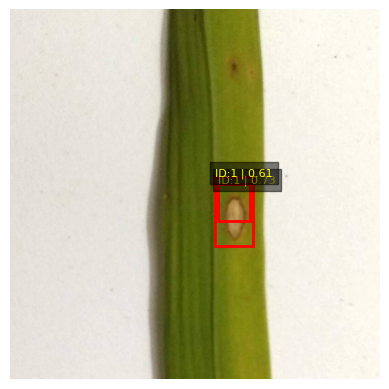

In [ ]:
import torch
from PIL import Image
import torchvision.transforms as T
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# --- ІНІЦІАЛІЗАЦІЯ МОДЕЛІ ---
def get_model(num_classes=4):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

# --- ЗАГРУЗКА МОДЕЛІ ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = get_model(num_classes=4)
model.load_state_dict(torch.load("/content/drive/MyDrive/replic_of_doc/best_model.pth", map_location=device))
model.to(device)
model.eval()

# --- ОБРОБКА ЗОБРАЖЕННЯ ---
def predict_on_image(image_path, score_threshold=0.5):
    transform = T.Compose([
        T.ToTensor()
    ])
    image = Image.open(image_path).convert("RGB")
    input_tensor = transform(image).to(device)

    with torch.no_grad():
        outputs = model([input_tensor])[0]  # batch of 1

    boxes = outputs["boxes"].cpu()
    scores = outputs["scores"].cpu()
    labels = outputs["labels"].cpu()

    # Фільтрація по порогу
    keep = scores > score_threshold
    boxes = boxes[keep]
    scores = scores[keep]
    labels = labels[keep]

    # --- ВІЗУАЛІЗАЦІЯ ---
    fig, ax = plt.subplots(1)
    ax.imshow(image)

    for box, score, label in zip(boxes, scores, labels):
        x1, y1, x2, y2 = box
        rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                 linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        ax.text(x1, y1 - 5, f"ID:{label.item()} | {score:.2f}", color='yellow',
                fontsize=8, bbox=dict(facecolor='black', alpha=0.5))

    plt.axis("off")
    plt.show()

# --- ВИКЛИК ---
predict_on_image("/content/drive/MyDrive/replic_of_doc/dataset/images/IMG_20190420_193215.jpg")


In [ ]:
!pip install pycocotools

In [ ]:
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.datasets import CocoDetection
from torchvision.transforms import functional as F
from torch.utils.data import DataLoader
from PIL import Image
from collections import defaultdict
import numpy as np
from tqdm import tqdm
import json
import os
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

# --- Device setup ---
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print("🖥️ Device:", device)

# --- Confidence threshold ---
confidence_threshold = 0.78

# --- Dataset transform ---
class CocoTransform:
    def __call__(self, image, target):
        if not isinstance(image, Image.Image):
            image = Image.fromarray(image)
        return F.to_tensor(image), target

def get_coco_dataset(img_dir, ann_file):
    return CocoDetection(
        root=img_dir,
        annFile=ann_file,
        transforms=CocoTransform()
    )

def collate_fn(batch):
    return tuple(zip(*batch))

# --- Load dataset ---
val_dataset = get_coco_dataset(
    img_dir="/content/drive/MyDrive/replic_of_doc/fasterrcnn_dataset/val",
    ann_file="/content/drive/MyDrive/replic_of_doc/fasterrcnn_dataset/annotations/instances_val.json"
)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, collate_fn=collate_fn)

# --- Load trained model ---
def get_model(num_classes):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

num_classes = 4  # include background
model = get_model(num_classes)
model.load_state_dict(torch.load("best_model.pth", map_location=device))
model.to(device)
model.eval()

# --- COCO evaluation format conversion ---
def prepare_for_coco_eval(model, data_loader, device):
    model.eval()
    results = []
    for images, targets in tqdm(data_loader, desc="Predicting"):
        images = [img.to(device) for img in images]
        outputs = model(images)

        for i, output in enumerate(outputs):
            image_id = int(targets[i][0]['image_id'])
            boxes = output['boxes'].detach().cpu()
            scores = output['scores'].detach().cpu()
            labels = output['labels'].detach().cpu()

            for box, score, label in zip(boxes, scores, labels):
                if score < confidence_threshold:
                    continue
                x_min, y_min, x_max, y_max = box.numpy()
                results.append({
                    "image_id": image_id,
                    "category_id": int(label),
                    "bbox": [float(x_min), float(y_min), float(x_max - x_min), float(y_max - y_min)],
                    "score": float(score)
                })
    return results

# --- COCO mAP calculation ---
def evaluate_map(coco_gt, coco_results):
    coco_dt = coco_gt.loadRes(coco_results)
    coco_eval = COCOeval(coco_gt, coco_dt, iouType='bbox')
    coco_eval.evaluate()
    coco_eval.accumulate()
    coco_eval.summarize()
    return coco_eval.stats

# --- IOU helper ---
def compute_iou(box1, box2):
    x1, y1, x2, y2 = box1
    x1g, y1g, w, h = box2
    x2g = x1g + w
    y2g = y1g + h

    xi1 = max(x1, x1g)
    yi1 = max(y1, y1g)
    xi2 = min(x2, x2g)
    yi2 = min(y2, y2g)

    inter_area = max((xi2 - xi1), 0) * max((yi2 - yi1), 0)
    box1_area = (x2 - x1) * (y2 - y1)
    box2_area = w * h
    union_area = box1_area + box2_area - inter_area
    return inter_area / union_area if union_area > 0 else 0

# --- Global metrics with confidence threshold ---
def compute_metrics(preds, targets, iou_threshold=0.5):
    tp_total = 0
    fp_total = 0
    fn_total = 0

    for pred, target in zip(preds, targets):
        pred_boxes = pred['boxes'].cpu()
        pred_labels = pred['labels'].cpu()
        pred_scores = pred['scores'].cpu() if 'scores' in pred else torch.ones(len(pred_labels))

        # Filter out low-confidence predictions
        keep = pred_scores > confidence_threshold
        pred_boxes = pred_boxes[keep]
        pred_labels = pred_labels[keep]

        tgt_boxes = torch.tensor([obj['bbox'] for obj in target], dtype=torch.float32)
        tgt_labels = torch.tensor([obj['category_id'] for obj in target])

        matched = set()
        for i in range(len(pred_boxes)):
            pred_box = pred_boxes[i]
            pred_label = pred_labels[i]

            best_iou = 0
            best_idx = -1

            for j in range(len(tgt_boxes)):
                if j in matched or pred_label != tgt_labels[j]:
                    continue
                tgt_box = tgt_boxes[j]
                iou = compute_iou(pred_box, tgt_box)
                if iou > best_iou:
                    best_iou = iou
                    best_idx = j

            if best_iou >= iou_threshold and best_idx >= 0:
                tp_total += 1
                matched.add(best_idx)
            else:
                fp_total += 1

        for j in range(len(tgt_boxes)):
            if j not in matched:
                fn_total += 1

    precision = tp_total / (tp_total + fp_total + 1e-6)
    recall = tp_total / (tp_total + fn_total + 1e-6)
    f1 = 2 * precision * recall / (precision + recall + 1e-6)
    accuracy = tp_total / (tp_total + fp_total + fn_total + 1e-6)

    print(f"\nTP: {tp_total}, FP: {fp_total}, FN: {fn_total}")
    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }

# --- Run full evaluation ---
def run_evaluation():
    print("\n🔍 Running inference...")
    coco_preds = prepare_for_coco_eval(model, val_loader, device)

    print("\n📊 Computing COCO mAP...")
    json_path = "temp_results.json"
    with open(json_path, "w") as f:
        json.dump(coco_preds, f)
    coco_gt = COCO("/content/drive/MyDrive/replic_of_doc/fasterrcnn_dataset/annotations/instances_val.json")
    coco_stats = evaluate_map(coco_gt, json_path)
    os.remove(json_path)

    print("\n📊 Computing overall accuracy, precision, recall, F1-score...")
    preds = []
    gts = []
    with torch.no_grad():
        for imgs, tgts in tqdm(val_loader, desc="Collecting predictions"):
            imgs = [img.to(device) for img in imgs]
            outputs = model(imgs)
            preds.extend(outputs)
            gts.extend(tgts)

    overall_metrics = compute_metrics(preds, gts)
    print("\n🔎 Overall Evaluation Metrics:")
    print(f"Accuracy:  {overall_metrics['accuracy']:.4f}")
    print(f"Precision: {overall_metrics['precision']:.4f}")
    print(f"Recall:    {overall_metrics['recall']:.4f}")
    print(f"F1 Score:  {overall_metrics['f1']:.4f}")

if __name__ == "__main__":
    run_evaluation()


🖥️ Device: cuda
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!

🔍 Running inference...


Predicting: 100%|██████████| 10/10 [00:02<00:00,  4.80it/s]



📊 Computing COCO mAP...
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.01s).
Accumulating evaluation results...
DONE (t=0.00s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.031
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.101
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.012
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.051
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.036
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.039
 Average Recall     (AR) @[ IoU=0.50:0.9


TP: 7, FP: 1, FN: 299

🔎 Overall Evaluation Metrics:
Accuracy:  0.0228
Precision: 0.8750
Recall:    0.0229
F1 Score:  0.0446


In [ ]:
!python rpn.py

[DEBUG] Reading /content/drive/MyDrive/replic_of_doc/dataset/labels/blast_rotated_021.txt
[DEBUG] line: 1 0.5166666666666667 0.4916666666666667 0.21333333333333335 0.16333333333333333
[DEBUG] line: 1 0.8383333333333334 0.15000000000000002 0.19 0.29333333333333333
[DEBUG] Final parsed boxes shape: torch.Size([2, 4])
[DEBUG] Reading /content/drive/MyDrive/replic_of_doc/dataset/labels/blight_orig_017.txt
[DEBUG] line: 2 0.3416666666666667 0.4516666666666667 0.3433333333333334 0.7633333333333334
[DEBUG] Final parsed boxes shape: torch.Size([1, 4])
[DEBUG] Reading /content/drive/MyDrive/replic_of_doc/dataset/labels/brownspot_orig_025.txt
[DEBUG] line: 0 0.445 0.46166666666666667 0.21000000000000002 0.17
[DEBUG] line: 0 0.5016666666666667 0.925 0.09000000000000001 0.06333333333333334
[DEBUG] Final parsed boxes shape: torch.Size([2, 4])
[DEBUG] Reading /content/drive/MyDrive/replic_of_doc/dataset/labels/blight_orig_052.txt
[DEBUG] line: 2 0.5 0.56 0.6933333333333334 0.8733333333333334
[DEBUG]

Ця хуйня не праціє ніяк вже, я тільки перепробував(можемо на похуй закинути їй фото з того доку який у нас є, а скажемо що да да все працює, а якщо не працює скажемо що у нас все працює)

In [ ]:
!python mask_rcnn.py

✅ GPU is available: Tesla T4
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
🚀 Starting training...
⚠️ WARNING: No valid annotations found after 327 attempts. Returning dummy sample.
⚠️ WARNING: No valid annotations found after 327 attempts. Returning dummy sample.
⚠️ WARNING: No valid annotations found after 327 attempts. Returning dummy sample.
⚠️ WARNING: No valid annotations found after 327 attempts. Returning dummy sample.
⚠️ WARNING: No valid annotations found after 327 attempts. Returning dummy sample.
⚠️ WARNING: No valid annotations found after 327 attempts. Returning dummy sample.
⚠️ WARNING: No valid annotations found after 327 attempts. Returning dummy sample.
⚠️ WARNING: No valid annotations found after 327 attempts. Returning dummy sample.
⚠️ WARNING: No valid annotations found after 327 attempts. Returning dummy sample.
⚠️ WARNING: No valid annotations found after 327 attempts. Returning dummy sample.
Traceback (most recent call last):


In [ ]:
!git clone https://github.com/ultralytics/yolov3

Cloning into 'yolov3'...
remote: Enumerating objects: 12157, done.
remote: Counting objects: 100% (81/81), done.
remote: Compressing objects: 100% (57/57), done.
remote: Total 12157 (delta 40), reused 24 (delta 24), pack-reused 12076 (from 2)
Receiving objects: 100% (12157/12157), 10.69 MiB | 10.90 MiB/s, done.
Resolving deltas: 100% (8237/8237), done.
Updating files: 100% (138/138), done.


Для yolov3

In [ ]:
%cd yolov3

[Errno 2] No such file or directory: 'yolov3'
/content/drive/MyDrive/replic_of_doc/pytorch-YOLOv4


In [ ]:
!pip install -r requirements.txt

  Using cached numpy-1.22.2.zip (11.4 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached torch-2.0.1-cp311-cp311-manylinux1_x86_64.whl.metadata (24 kB)
  Using cached tensorboardX-2.6.2.2-py2.py3-none-any.whl.metadata (5.8 kB)
  Using cached easydict-1.9.tar.gz (6.4 kB)
  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu11-11.7.99-2-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu11-11.7.99-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cuda_cupti_cu11-11.7.101-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu11-8.5.0.96-2-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu11-11.10.3.66-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cufft_cu11-10.9.0.58-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cache

In [ ]:
!python train.py --img 416 --batch 16 --epochs 100 --data "/content/drive/MyDrive/replic_of_doc/RiceDiseaseDataset_yolo_test/rice_detection.yaml" --cfg "/content/drive/MyDrive/replic_of_doc/yolov3/models/yolov3.yaml" --optimizer Adam


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/content/drive/MyDrive/replic_of_doc/pytorch-YOLOv4/train.py", line 23, in <module>
    import torch
  File "/usr/local/lib/python3.11/dist-packages/torch/__init__.py", line 1382, in <module>
    from .functional import *  # noqa: F403
  File "/usr/local/lib/python3.11/dist-packages/torch/functional.py", line 7, in <module>
    import torch.nn.functional as F
  File "/usr/local/lib/python3.11/dist-packages/torch/nn/__init__.py", line 1, in <module>
    from .modules import *  # noqa: F403
  File "/usr/local/lib/pyt

In [ ]:
!python train.py --img 416 --batch 16 --epochs 100 --data "/content/drive/MyDrive/replic_of_doc/RiceDiseaseDataset_yolo_test/rice_detection.yaml" --cfg "/content/drive/MyDrive/replic_of_doc/yolov3/models/yolov3.yaml"


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/content/drive/MyDrive/replic_of_doc/pytorch-YOLOv4/train.py", line 23, in <module>
    import torch
  File "/usr/local/lib/python3.11/dist-packages/torch/__init__.py", line 1382, in <module>
    from .functional import *  # noqa: F403
  File "/usr/local/lib/python3.11/dist-packages/torch/functional.py", line 7, in <module>
    import torch.nn.functional as F
  File "/usr/local/lib/python3.11/dist-packages/torch/nn/__init__.py", line 1, in <module>
    from .modules import *  # noqa: F403
  File "/usr/local/lib/pyt

In [ ]:
!git clone https://github.com/Tianxiaomo/pytorch-YOLOv4

Cloning into 'pytorch-YOLOv4'...
remote: Enumerating objects: 1052, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 1052 (delta 4), reused 0 (delta 0), pack-reused 1043 (from 1)
Receiving objects: 100% (1052/1052), 2.39 MiB | 8.27 MiB/s, done.
Resolving deltas: 100% (646/646), done.


Для yolov4

In [ ]:
%cd pytorch-YOLOv4

[Errno 2] No such file or directory: 'pytorch-YOLOv4'
/content/drive/MyDrive/replic_of_doc/pytorch-YOLOv4


In [ ]:
!pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.4/11.4 MB 66.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of scikit-image to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of matplotlib to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of opencv-python to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of contourpy to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of scipy to determine which version is compatible with other requirements. This could take a while.
     ━━━━

In [ ]:
!pip install torchvision==0.16.0


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 84.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.2/670.2 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 57.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 35.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 53.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.8/209.8 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9

In [ ]:
!python train.py --img 416 --batch 16 --epochs 100 --data "/content/drive/MyDrive/replic_of_doc/RiceDiseaseDataset_yolo_test/rice_detection.yaml" --cfg "/content/drive/MyDrive/replic_of_doc/pytorch-YOLOv4/cfg/yolov4.cfg" --optimizer Adam

Traceback (most recent call last):
  File "/content/drive/MyDrive/replic_of_doc/pytorch-YOLOv4/train.py", line 23, in <module>
    import torch
  File "/usr/local/lib/python3.11/dist-packages/torch/__init__.py", line 235, in <module>
    from torch._C import *  # noqa: F403
    ^^^^^^^^^^^^^^^^^^^^^^
KeyboardInterrupt
^C


In [ ]:
!python train.py --img 416 --batch 16 --epochs 100 --data "/content/drive/MyDrive/replic_of_doc/RiceDiseaseDataset_yolo_test/rice_detection.yaml" --cfg "/content/drive/MyDrive/replic_of_doc/pytorch-YOLOv4/cfg/yolov4.cfg"


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/content/drive/MyDrive/replic_of_doc/pytorch-YOLOv4/train.py", line 23, in <module>
    import torch
  File "/usr/local/lib/python3.11/dist-packages/torch/__init__.py", line 1382, in <module>
    from .functional import *  # noqa: F403
  File "/usr/local/lib/python3.11/dist-packages/torch/functional.py", line 7, in <module>
    import torch.nn.functional as F
  File "/usr/local/lib/python3.11/dist-packages/torch/nn/__init__.py", line 1, in <module>
    from .modules import *  # noqa: F403
  File "/usr/local/lib/pyt

In [ ]:
!touch rpn.py

In [ ]:
!python rpn.py

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/100
Train Loss: 0.1652 | Train Accuracy: 0.9725
Validation Loss: 0.4536 | Validation Accuracy: 1.0000
Best model saved!
Epoch 2/100
Train Loss: 0.0101 | Train Accuracy: 1.0000
Validation Loss: 0.0058 | Validation Accuracy: 1.0000
Best model saved!
Epoch 3/100
Train Loss: 0.0014 | Train Accuracy: 1.0000
Validation Loss: 0.0007 | Validation Accuracy: 1.0000
Best model 